In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from slime.city import City
import pandas as pd

In [2]:
# ox.config(use_cache=False,
#           log_console=True,
#           useful_tags_way=ox.settings.useful_tags_way + ['railway'])

# G = ox.graph_from_place("Beijing, China",  
#                         retain_all=False, truncate_by_edge=True, simplify=True,
#                         custom_filter='["railway"~"rail"]')
# ox.save_graphml(G, 'database/beijing_railway.graphml')
# load graph data
# G = ox.load_graphml('database/beijing_railway.graphml')
# fig, ax = ox.plot_graph(G)

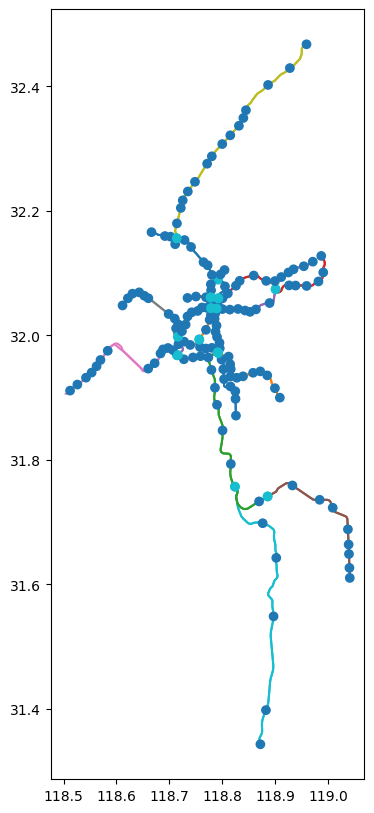

In [3]:

stations = gpd.read_file('database/nanjing_nodes.geojson')
routes = gpd.read_file('database/nanjing_edges.geojson')
# drop irrelevant columns and null value
stations = stations.drop(['name', 'marker-symbol', 'marker-size'], axis=1)
routes = routes.drop(['name', 'ref'], axis=1)
stations = stations[~stations['marker-color'].isnull()].reset_index().drop(['index'], axis=1)
# gpd.options.display_precision = 4
fig, ax = plt.subplots(figsize=(10, 10))
stations.plot(ax=ax, column=stations['marker-color'], zorder=2)
routes.plot(ax=ax, column='stroke', zorder=1)
plt.show()

In [4]:
# preprocess node attribute
stations['lon'], stations['lat'] = stations.geometry.x, stations.geometry.y
stations['value'] = np.where(stations['marker-color']=='#ff2600', 10, 5)
min_x = min(stations['lon'])
min_y = min(stations['lat'])
stations['x'] = stations.lon.apply(lambda x: int((x - min_x) * (10**3)))
stations['y'] = stations.lat.apply(lambda y: int((y - min_y) * (10**3)))
stations = pd.DataFrame(stations.drop(['geometry'], axis=1))

In [5]:
routes.head()

,stroke,geometry
0,#f1bc1a,"LINESTRING (118.82147 31.75946, 118.82281 31.7..."
1,#f1bc1a,"LINESTRING (118.87229 31.34309, 118.87190 31.3..."
2,#ca8687,"LINESTRING (119.04148 31.61031, 119.04083 31.6..."
3,#ca8687,"LINESTRING (118.88598 31.74120, 118.90000 31.7..."
4,#da60cd,"LINESTRING (118.50250 31.90719, 118.50285 31.9..."


In [6]:
stations.head()

,marker-color,lon,lat,value,x,y
0,#797979,118.863858,32.041670,5,351,698
1,#797979,118.779027,32.052965,5,266,709
2,#797979,118.982163,32.086573,5,470,743
3,#797979,118.542290,31.931998,5,30,588
4,#ff2600,118.789430,32.044122,10,277,701


1228
1881
1823
1691
1620
1494
1415
1320
1278
1186
1135
1117
1029
968
946
882
825
768
731
674
669
639
602
542
513
486
446
411
383
337
337
309
289
288
270
253
237
230
219
205
197
195
186
183
169
172
156
150
135
134
130
125


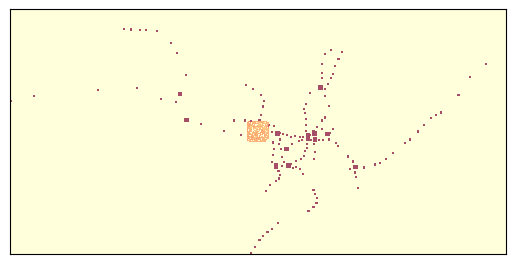

In [7]:

city = City(city_shape=(max(stations.x) + 50, max(stations.y) + 50), foods=stations, mould_shape=(50, 50), coverage=0.5, decay=0.9, sensor_offset=9)

city.animate(frames=50, interval=100, filename="output/11.gif")